(9)=
# Chapter 9: Simulations

Simulations are a major component of modern chemical research either in conjunction with experimental work or by itself. A *digital chemical simulation* is a representation or mimic of a physical or chemical process using a computer with enough detail that the results provide meaningful and useful insights into the real process. Simulations do not need represent every aspect of the real world as long as the omitted details do not reduce the accuracy or precision to a level that the simulation is no longer useful.

Modern chemical simulations are often quite complex and are performed with a range of free or commercial software that regrettably can obfuscate the underlying methods. This chapter aims to introduce simulations with simple methodologies that can be easily coded in Python, NumPy, and SciPy. These simulations are not designed for use in a research setting due to the low level of sophistication and do not represent the current state-of-art in the field of chemical simulations. Some of these simulations are also not as computationally efficient as they could be because efficiency is sometimes sacrificed here for simplicity and accessibility.

The simulations in this chapter assume the following imports from NumPy, SciPy, and matplotlib.

In [54]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

(9.1)=
## 9.1 Deterministic Simulations

Simulations with no random variables have fixed outcomes dictated by the code and input parameters. If these simulations are run multiple times using the same parameters, the outcomes of the simulations will be exactly identical. This is a category if simulations known as *deterministic simulations*. Even though many physical and chemical processes are driven by randomness, such as the random movements and collisions of molecules, they can often still be simulated deterministically because with a large number of molecules makes the randomness conform to predictable patterns. This is the case with Nuclear Magnetic Resonance (NMR) splitting patters and chemical kinetics among many others.

(9.1.1)=
### 9.1.1 Nuclear Magnetic Resonance Splitting

The splitting patters observed in $^1$H NMR spectra are typically generated by neighboring protons possessing spins of +1/2 or –1/2 which alter the magnetic field around the observed proton. Even though the signs of the neighboring protons are random, the sample contains such a large number of molecules that the ratio should be quite close to the theoretical value of approximately 1:1. As a result, we can simulate the splitting patterns generated in $^1$H NMR spectra deterministically by splitting all peaks into 1:1 doublets for every neighboring proton.

A recursive function is defined below that generates the splitting pattern generated by equivalent protons. The function takes in the chemical shift of the peak(s) (`peaks`), the number of equivalent neighboring protons (`n`), the coupling constant (`J`) in Hz, and the frequency of observation (`freq`) in MHz; and it returns a list of the split peaks in ppm. Each time the function is called, it splits the existing peak(s) into doublets, and the function is then called again if more splits are necessary due to multiple equivalent neighboring protons. The function below also includes validity checks to ensure the user-provided parameters are what the function expects.

In [55]:
def split(peaks, n, J, freq=400):
    '''(list, int, float, freq=num) -> list
    Takes in a list of peak ppm values for a single 
    resonance(peaks),the number of identical neighboring 
    protons(n), the coupling constant (J) in Hz, and the 
    frequency of observation (freq) in MHz and returns a 
    list of ppm values for all peaks in the splitting pattern.
    '''
    # check validity of input values
    if type(peaks) != list:
        peaks = list([peaks])
    if type(n) != int:
        print('Error: n must be an integer.')
        return None
    
    # split the peak(s)
    J_ppm  = J / freq
    new_peaks = []
    for peak in peaks:
        new_peaks.extend([peak + 0.5 * J_ppm, peak - 0.5 * J_ppm])
        
    n =n - 1
    
    # perform next split or return result
    if n > 0:
        return split(new_peaks, n, J, freq=freq)
    else:
        return new_peaks

In [56]:
split(1.00, 2, J=3.4, freq=400)

[1.0085000000000002, 1.0, 1.0, 0.9915]

In the above example, a peak at 1.00 ppm has two neighboring protons that couple with it at 3.4 Hz, and the sample is observed at 400 MHz. There are four resulting peaks in the output list, but two peaks are at the same chemical shift of 1.00 ppm. This results in three peaks with the one at 1.00 ppm being twice the magnitude as the other two. We can visualize this by binning the peaks and generating a line plot.

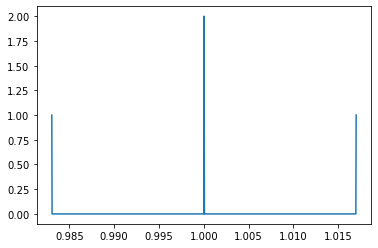

In [57]:
signal, ppm = np.histogram(split([1.00], 2, J=6.8), bins=1000)
plt.plot(ppm[1:], signal)

If there are multiple inequivalent groups of neighboring proton, this often results in more complex splitting patters due to additional protons and additional coupling constants. This can be simulated by nesting the `split()` function and providing the different coupling constants. Below, we simulate a splitting pattern for a proton coupled with two protons with J = 9.8 Hz and another proton with J = 10.8. This generates a doublet of triplets.

Text(0.5, 0, 'Chemical Shift, ppm')

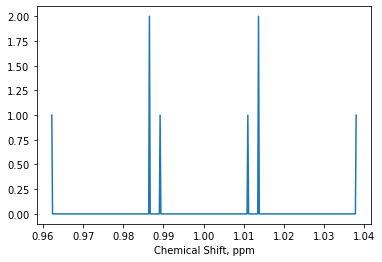

In [58]:
signal, ppm = np.histogram(split(split([1.00], 1,  J=10.8), 2, J=9.8), bins=400)
plt.plot(ppm[1:], signal)
plt.xlabel('Chemical Shift, ppm')

(9.1.2)=
### 9.1.2 Single-Step Stepwise Chemical Kinetics

Another phenomenon that can be simulated deterministically is the progress of a chemical reaction with respect to time. Many chemical reaction slow over the course of the reaction as the result of diminishing reactant concentrations. This is because many reaction rates are dependent on the concentration of at least one staring material, and as the reaction progresses, starting material is consumed slowing the reaction.

One method for simulating this phenomenon is to incrementally calculate the rate of the chemical reaction at various points in the reaction based on the current concentrations. That is, at each small time step of the reaction, use the concentration(s) to calculate the current reaction rate and then increased/decreased the reaction concentrations by the amount calculated.

For example, we can simulate the following single-step chemical reaction of A $\rightarrow$ P. Because this is an elementary step, the rate law is derivable from the stoichiometry where rate is M/s, $k_{rxn}$ is the rate constant, and \[A\] is the concentration of A in molarity (M).

$$ Rate=k_{rxn}[A]  $$

To keep the math simple, we will make each step in the reaction one second. That way, if the rate is 0.1 M/s, we can simply subtract 0.1 M for one second of reaction. Let us choose a *k* = 0.05 s$^{-1}$ and an initial [A] = 1.00 M. Therefore, the rate = (0.05 s$^{-1}$)(1.00 M) = 0.05 M/s, so the concentration of A should decrease by 0.05 M in the first second giving us 0.95 M. Now the rate of reaction is (0.05 s$^{-1}$)(0.95 M) = 0.0475 M/s, so we now subtract 0.0475 M from [A] for the next second of reaction to get 0.903 M. This continues for the entire duration of the simulation. Code for executing this process is shown below. A `for` loop runs the above process for each second of the simulation and records the new concentrations of A and P in NumPy arrays via assignment.

In [59]:
A, P = 1.00, 0.00 # molarity, M
k = 0.05 # 1/s for a first-order reaction 
length = 100  # length of simulation in seconds 
time = range(length + 1)

# create arrays to hold calculated concentrations
A_conc = np.empty(length + 1)
P_conc = np.empty(length + 1)

# simulation
for sec in time:
    # record concentration
    A_conc[sec] = A
    P_conc[sec] = P
    # recalculate rate
    rate = k * A
    # recalculate new concentration
    A -= rate
    P += rate

You may be wondering why the first lines of code in the `for` loop record the concentrations instead of first decreasing them. This is because we need to record the initial concentration first before recalculating them. The next iteration will record the new concentrations before again recalculating rates and concentrations. Below is a plot of the simulation results.

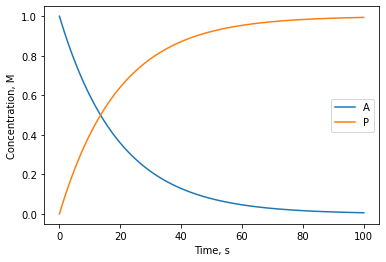

In [60]:
plt.plot(time, A_conc, label='A')
plt.plot(time, P_conc, label='P')
plt.xlabel('Time, s')
plt.ylabel('Concentration, M')
plt.legend()

We can overlay this plot with the theoretical values using the integrated first-order rate law below.

In [61]:
t = np.arange(0,100, 10)
A_theor = 1.0*np.exp(-k*t)
P_theor = np.ones(10) - A_theor

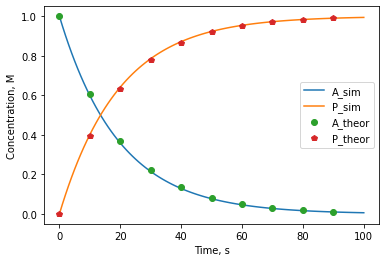

In [62]:
plt.plot(time, A_conc, '-', label='A_sim')
plt.plot(time, P_conc, '-', label='P_sim')
plt.xlabel('Time, s')
plt.ylabel('Concentration, M')

plt.plot(t, A_theor, 'o', label='A_theor')
plt.plot(t, P_theor, 'p', label='P_theor')

plt.legend()

The theoretical equation and simulation results are in good agreement. A closer inspection of the two shows a slight discrepancy between the two which is most noticeable earlier in the simulation. This is because the simulation only adjusts the rate every second while the theoretical equation can be thought of as recalculating the rate for infinitely small increments making the theoretical model more accurate.

(9.1.3)=
### 9.1.3 Multistep Stepwise Chemical Kinetics

If we have a well-established theoretical equation for the above reaction of A $\rightarrow$ P, why do we need the simulation? With this methodology, we can simulate more complicated reaction mechanisms, such as the multistep reaction below, even if we do not have the theoretical rate law in hand.

$$ A \rightleftharpoons I $$

$$ I + B \rightleftharpoons P $$ 

In this reaction, starting material A converts to intermediate I in the first step followed by starting material B combining with I to form the product P. Both of these steps are reversible, so there are four rate constants. The code and output of the simulation are below. Unlike the previous simulation, the simulation below appends values to lists (e.g., `A_conc`).

In [63]:
A_conc, B_conc, I_conc, P_conc = [], [], [], []
A, B, I, P = 1.0, 0.6, 0.0, 0.0  # initial conc, M
k1, k2, kr1, kr2 = 0.091, 0.1, 0.03, 0.01 # rate const
length = 200

# the simulation
for sec in range(length):
    A_conc.append(A)
    I_conc.append(I)
    B_conc.append(B)
    P_conc.append(P)
    # recalculate rates
    rate_1 = k1 * A
    rate_r1 = kr1 * I
    rate_2 = k2 * B * I
    rate_r2 = kr2 * P
    #recalculate concentrations after next time increment
    A = A - rate_1 + rate_r1
    I = I + rate_1 - rate_2 - rate_r1 + rate_r2
    B = B - rate_2 + rate_r2
    P = P + rate_2 - rate_r2

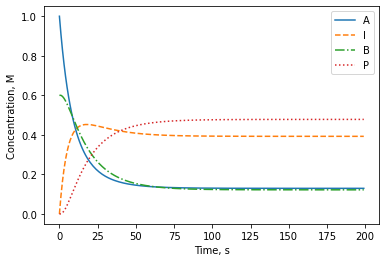

In [64]:
plt.plot(range(length), A_conc, label='A', ls='-')
plt.plot(range(length), I_conc, label='I', ls='--')
plt.plot(range(length), B_conc, label='B', ls='-.')
plt.plot(range(length), P_conc, label='P', ls=':')
plt.xlabel('Time, s')
plt.ylabel('Concentration, M')
plt.legend()

A word of caution regarding the above simulations: if the rate constants are increased enough, oscillating behavior and negative concentrations will be observed... the latter of which is clearly wrong. This is because the simulation fails to recalculation the rates fast enough for the simulation, but this can be remedied by decreasing the step size.

(9.1.4)=
### 9.1.4 Chemical Kinetics and ODEINT

Another approach to performing the above kinetic simulations is to integrate the differential equations. For an introduction to integrating differential equations, see [section 8.4.4](8.4.4). Below we will simulate a two step reaction where the first step is reversible. Because the following are the elementary steps, the rate equations can be inferred from the reaction stoichiometry.

$$ A \rightleftharpoons B \rightarrow P $$

The three differential equations tracking the concentrations of A, B, and P are shown below where $k_1$ and $k_{r1}$ are the forward and reverse rate constants, respectively, for the first step and $k_2$ is the rate constant for the second step.

$$ \frac{d[A]}{dt} = k_1[A] + k_{r1}[B] $$

$$ \frac{d[B]}{dt} = k_1[A] + k_2[B] - k_{r1}[B]$$ 

$$ \frac{d[P]}{dt} = k_2[B] $$ 

As is done in section 8.4.4, a Python function is created containing the differential equations, but in contrast to chapter 8, the differential equation for d[P]/dt is also included in the Python function instead  of calculating [P] after the integration.

In [65]:
k1, kr1, k2 = 0.2, 0.6, 0.3
A0, B0, P0 = 1.0, 0.0, 0.0
t = np.linspace(0, 50, 50)

def rates(conc, t):
    A, B, P = conc
    dAdt = -k1 * A + kr1 * B
    dBdt = k1 * A - k2 * B - kr1 * B
    dPdt = k2 * B
    
    return dAdt, dBdt, dPdt

Because the `odeint()` function only takes the initial concentration (`A0`, `B0`, and `P0`) as a single argument, they need to be placed in a tuple.

In [66]:
A_t, B_t, P_t = scipy.integrate.odeint(rates, (A0, B0, P0),t).T

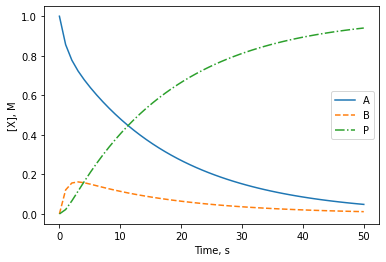

In [67]:
plt.plot(t, A_t, '-', label='A')
plt.plot(t, B_t, '--', label='B')
plt.plot(t, P_t, '-.',label='P')
plt.xlabel('Time, s')
plt.ylabel('[X], M')
plt.legend()

(9.2)=
## 9.2 Stochastic Simulations

Unlike the deterministic simulations above, if the same code for a stochastic simulation is run multiple times, the results will vary at least slightly, though the overall patterns should be similar. This is because the outcome of stochastic simulations is determined by (pseudo)random number generators. It is as if the results of the simulation are dictated by the flip of a coin or roll of a die. This analogy is so good that rolling dice repeatedly can simulate radioactive decay kinetics among other things. We will use NumPy's `random` module to generate random values for the simulations.

'''{note}
There is a random component to some of the following code, so exact results may vary.
'''

(9.2.1)=
### 9.2.1 Radioactive Decay

Radioactive decay is a random process, so logically it can be simulated as such. Every radioactive atom has a fixed probability of decaying each second just like a die has a fixed probability of rolling a one. A `for` loop is used for each second or step of the simulation, and a random number generator is used in each step to decide how many atoms decay. The `np.random.binomial()` function is used here to generate a series of zeros and ones with a set probability of generating a one. In this simulation, a one signifies a decaying atom. These decayed atoms are tallied and subtracted from the current number of remaining atoms, and this value is recorded. 

In [69]:
# this code cell is hidden on Jupyter Book
np.random.seed(18)

In [68]:
starting_atoms = 1000
length = 10000  # length of simulation
num_atoms = starting_atoms
record = []
for x in range(length):
    record.append(num_atoms)
    # "rolls" dice and tallies up number of zeros
    rolls = np.random.binomial(1, p=0.001, size=num_atoms)
    decayed_count = np.sum(rolls)
    # deduct decayed nuclei from the total
    num_atoms -= decayed_count
record = np.array(record)

The results stored are in an array called `record` which can be plotted along with the first-order integrated rate law to see how the two compare. Being that there is a 1/1000 probability in the above simulation of each atom generating a one (decay), the rate constant ($k$) is 0.001 s$^{-1}$. For ease of viewing, only twenty data points from the simulation are plotting below.

Text(0, 0.5, 'Atoms Remaining')

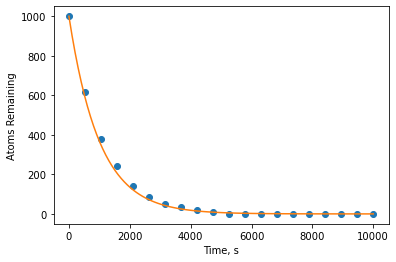

In [70]:
# plot of simulation
step = np.linspace(0, length, 20)
plt.plot(step, record[::500], 'o', label='Simulation Results')
# plot of theoretical rate law
t = np.linspace(0, length, 100)
plt.plot(t, starting_atoms*np.exp(-1/1000 * t), label='Theoretical Model')
plt.xlabel('Time, s')
plt.ylabel('Atoms Remaining')

The simulation and theoretical model are in good but not perfect agreement. The deviation is a result of the simulation using random numbers and only simulating a relatively small number of molecules. If this simulation were run with increasingly larger number of molecules, the results are expected to converge on the theoretical prediction.

(9.2.2)=
### 9.2.2 Confidence Intervals

Uncertainty is a part of all data, and uncertainty around a repeatedly measured and calculated value is often represented in the form of a 95% confidence interval (CI). This is the interval around the mean that has a 95% chance of containing the true value. Another way of describing 95% CI is that if we were to repeatedly collect a data set and calculate the 95% CI, the true value should be, statistically speaking, inside the confidence interval 95% of the time. Performing these experiments would be tedious, but this can be simulated in Python relatively easily. 

The equation for calculating the 95% CI is shown below whereis the average value in a set of repeated1 measurements, s is the standard deviation (corrected), t is the statistical t value from a table, and N is the degrees of freedom. For 20 samples per set, t = 2.09 and N = 19.

$$ 95\%CI = \bar{x} \pm \frac{ts}{\sqrt{N}} $$

We can simulated the data collection by picking a true value and generating twenty samples by adding random error to twenty copies of the true value. Using the simulated data set, the 95% CI can be calculated, and we can test whether or not the true value is inside the CI. If we repeated this procedure numerous times recording the success or failure of the true value being inside the CI, we can calculate the success rate as demonstrated below.

In [ ]:
# this code cell is hidden on Jupyter Book
np.random.seed(18)

In [71]:
trials = 100000
N = 20
t = 2.09
true = 6.2  # true value
# list contain a one for each time true inside 95% CI
in_interval = []

for trial in range(trials):
    # create synthetic data
    error = np.random.rand(N)
    data = np.ones(N) * true + (error - 0.5)
    # calculate the 95% CI
    avg = np.mean(data)
    CI_95 = t * np.std(data, ddof=1) / np.sqrt(N)
    lower = avg - CI_95
    upper = avg + CI_95
    # determine if true values is inside 95% CI
    if lower <= true <= upper:
        in_interval.append(1)

In [72]:
100 * np.sum(in_interval) / trials

94.783

The above simulation finds that almost 95% of the time, the true value is inside the 95% CI which is pretty close to what we expected. If this simulation is repeated, you will likely observe that the values are very often slightly below the expected 95%. This is the result of smaller data sets and should be closer to the theoretical value with increasing set size. 

(9.2.3)=
### 9.2.3 Random Flight Polymer

Polymers are long chains of repeating units called monomers. These chains can easily go for thousands of monomers and wind around in 3D space in seemingly random fashions. A single polymer chain can be made of a single type of monomer or multiple types and can be of varying lengths, but for the following polymer simulation, we will work with polymers of a fixed number of monomers and ignore the monomer types.  

One model for polymer conformation is a *random flight polymer* which assumes that the conformation of the polymer is entirely random. We can simulate a random flight polymer through a *random walk* by making each subsequent segment of polymer extend in a random direction and distance. For simplicity, we will simulate the polymer in only two dimensions, but this simulation can be expanded to a third dimension. The random element of the simulation is provided by a NumPy random number generator which generates a random length and direction for each new segment.
    
The general procedure for the following simulation is to start the polymer chain at coordinate (0, 0), and for each new segment, add a random value to the x-coordinate of the previous polymer end and another random value to the y-coordinate. Each new coordinate is then appended to a list of coordinates (`coords`) for analysis and visualization. This simulation is coded below. The random values are floats from -1 $\rightarrow$ 1. NumPy does not provide a function for generating this range, so we can modify the 0 $\rightarrow$ 1 range from the `np.random.rand()` function by subtracting 0.5 and multiplying by 2.

In [ ]:
# this code cell is hidden in Jupyter Book
np.random.seed(18)

In [73]:
segments = 3000
coords = [[0,0]]
for step in range(segments):
    x = coords[step][0] + 2 * (np.random.rand() - 0.5)
    y = coords[step][1] + 2 * (np.random.rand() - 0.5)
    coords.append([x, y])
coords = np.array(coords)

Text(0, 0.5, 'Position(y), au')

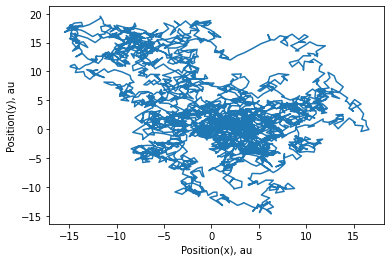

In [74]:
plt.plot(coords[:,0], coords[:,1])
plt.xlabel('Position(x), au')
plt.ylabel('Position(y), au')

The results of the simulation show a polymer strand winding around in an apparently random fashion. If we rerun the above simulation, a different looking polymer conformation will be generated.

## Further Reading

1. Downey, Allen Modeling and Simulation in Python. Book in progress. [https://github.com/AllenDowney/ModSimPy](https://github.com/AllenDowney/ModSimPy) (free resource)

2. Weiss, C. J. Introduction to Stochastic Simulations for Chemical and Physical Processes: Principles and Applications. J. Chem. Educ. 2017, 94 (12), 1904–1910. [https://doi.org/10.1021/acs.jchemed.7b00395](https://doi.org/10.1021/acs.jchemed.7b00395)

3. For examples of chemical kinetics scenarios to model, see: Bentenitis, N. A Convenient Tool for the Stochastic Simulation of Reaction Mechanisms. J. Chem. Educ. 2008, 85 (8), 1146−1150. [https://doi.org/10.1021/ed085p1146](https://doi.org/10.1021/ed085p1146)

## Exercises

1. Using `scipy.integrate.odeint()` and a differential equation, plot the concentration of starting material A with respect to time for a third-order reaction.

2. Create a simulation of the following single-step reaction and overlay it with the appropriate integrated rate law. The rate constant is 0.28 M$^{-1}$s$^{-1}$. Feel free to start with code from this chapter and modify it as needed.

    $$ 2A \rightarrow P $$

3. Plot the concentrations of A, B, C, and P with respect to time for the following three-step, non-reversible mechanism.


    $$ A \rightarrow B \rightarrow C \rightarrow P  $$

    The initial concentrations and rate constants are in the table below.
    
    | Step | Specie | [Specie]0, M | Rate Constant, s$^-1$ |
    | :--: | :---:  |  :---:       | :-----:               |
    | 1  |  A | 1.50 | 0.8  |
    | 2 | B | 0.00 | 0.4 |
    | 3 | C | 0.00 | 0.3 |
    | – | P | 0.00 | – |

4. Simulate the following chemical equilibrium where the forward rate is described by Rate$_f$ = (1.3 × 10$^{-2}$ M$^{-1}$s$^{-1}$)[A]$^2$ and the reverse rate is described by Rate$_r$ = (6.2 × 10$^{-3}$ s$^{-1}$)[B].

    $$ 2A \leftrightarrow B $$

    Use a `for` loop to simulate each second of reaction by calculating the rates and increasing/decreasing each         concentration appropriately. Record the concentrations in lists and plot the results. Start with 2.20 M of A and     1.72 M B and run the simulation for at least 200 seconds. Notice that the rates are in M/s.

5. In section 9.1.3, a two-step, reversible reaction is simulated. If the rate constant k$_{r1}$ is decreased to 0.01 s$^{-1}$, what effect on the reaction do you anticipate? Simulate this to see if your prediction is correct.

6. Simulate two competing, first-order reactions of starting material A forming product P$_1$ and P$_2$ and plot the resulting concentrations of both products versus time. Use k$_1$ = 0.02 M/s and k$_2$ = 0.04 M/s and start with 2.00 M A. What do you predict the plot of concentration versus time to look like and the ratio of products to be? Does your simulation agree?

7. Polymers that consist of two or more different monomers are known as copolymers. Simulate an addition copolymer consisting of two monomers: ethylene (28.06 g/mol) and styrene (104.16 g/mol) with a fixed length of a thousand units. Given the molecular weights of the two monomers above, calculate the weights for a thousand simulated polymer strands and generate a histograms of the frequency versus weight. Hint: try using the `np.random.binomial()` function with `p=0.5` and treat a zero as one monomer and a one is   the other.

8. Block copolymers are polymers where multiple monomer types are clustered along the polymer chain instead of being randomly dispersed. These clusters are called blocks which may be of random lengths as the polymer switches between monomer types. An example is shown below.

    $$ -A-A-A-A-A-A-A-B-B-B-B-B-B-A-A-A-A-B-B-B-A-A-A-A-A- $$

    Simulate a block copolymer consisting of two monomers with a total length of a hundred monomer units.

    Hint: Append monomers (0 or 1) to a list inside a `for` loop, and use a function from `np.random.binomial()` to     decide when to toggle between monomers types. Use `mono = 1 - mono` to make the switch.

9. The random flight polymer simulation presented in section 9.2.3 uses a `for` loop. As discussed in chapter 4, one of the virtues of NumPy is that it often avoids the computationally inefficient `for` loops. Below is the same simulation written in a single line of code leveraging the power of NumPy arrays. Briefly explain what it is doing and why it works.

    ~~~python
    loc = np.cumsum(np.random.randint(-1, high=2, size=(3000,2)), axis=0)
    ~~~

10. Proteins are nature polymers consisting of twenty common monomers called amino acids. Simulate a random protein strand of a thousand units long using the `np.random.randint()` function and a Python dictionary containing the single letter amino acid codes.

11. Confidence intervals

    a) Convert the code for calculating a 95% confidence interval in section 9.2.2 to a Python function that accepts     a number of samples as the one argument and returns the percentage of the time the true value is inside the         confidence interval. You will need to look up t values and generate a dictionary that converts degrees of           freedom (N) to t values.

    b) Using a `for` loop, calculate the percentage of the time the true value is in the 95% confidence interval for     each of the sample sizes in the above dictionary and plot the results. Describe the trend.

12. Simulate the diffusion of molecules along a single axis. Start all molecules at zero, and for each step of the simulation, add a random number, positive or negative, to each value in the array. Plot the results in a histogram.

13. Using the function from 9.1.1, simulate the splitting pattern for the tertiary proton in isopropyl alcohol ((CH$_3$)$_2$CHOH). In CDCl$_3$, this proton is observed at 3.82 ppm with a coupling constant of 6 Hz. Assume no coupling with the hydroxyl proton is observed.